<a href="https://colab.research.google.com/github/YoheiFukuhara/recommender-system/blob/main/08_mf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
BASE_PATH = '/content/drive/MyDrive/ColabNotebooks/ML/Recommend/output/'
df = pd.read_csv(BASE_PATH+'edited_rating.csv')
pd.options.display.float_format = '{:.2f}'.format
df.info()
display(df.describe())
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   movie_idx  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


,userId,movieId,rating,movie_idx
count,20000263.00,20000263.00,20000263.00,20000263.00
mean,69044.87,9041.57,3.53,3612.60
std,40038.63,19789.48,1.05,4154.44
min,0.00,1.00,0.50,0.00
25%,34394.00,902.00,3.00,887.00
50%,69140.00,2167.00,3.50,2085.00
75%,103636.00,4770.00,4.00,4677.00
max,138492.00,131262.00,5.00,26743.00


,userId,movieId,rating,movie_idx
0,0,2,3.50,2
1,0,29,3.50,29
2,0,32,3.50,32
3,0,47,3.50,47
4,0,50,3.50,50
...,...,...,...,...
20000258,138492,68954,4.50,13821
20000259,138492,69526,4.50,13929
20000260,138492,69644,3.00,13942
20000261,138492,70286,5.00,14060


In [3]:
N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

In [4]:
# split into train and test
df_train, df_test = train_test_split(df, train_size=0.8, random_state=0)

In [5]:
# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 10)        1384930     ['input_3[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 10)        267440      ['input_4[0][0]']                
                                                                                              

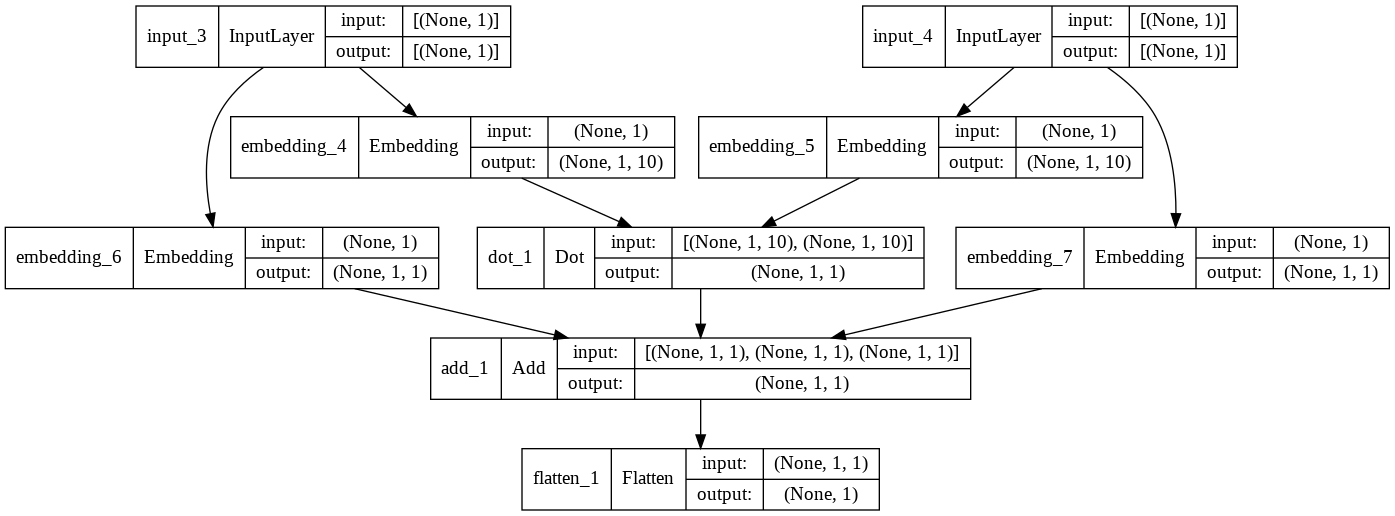

In [7]:
# keras model
u = tf.keras.layers.Input(shape=(1,))
m = tf.keras.layers.Input(shape=(1,))
u_embedding = tf.keras.layers.Embedding(N, K, 
                                        embeddings_regularizer=tf.keras.regularizers.l2(reg))(u) # (N, 1, K)
m_embedding = tf.keras.layers.Embedding(M, K, 
                                        embeddings_regularizer=tf.keras.regularizers.l2(reg))(m) # (N, 1, K)

u_bias = tf.keras.layers.Embedding(N, 1, 
                                   embeddings_regularizer=tf.keras.regularizers.l2(reg))(u) # (N, 1, 1)
m_bias = tf.keras.layers.Embedding(M, 1, 
                                   embeddings_regularizer=tf.keras.regularizers.l2(reg))(m) # (N, 1, 1)

x = tf.keras.layers.Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = tf.keras.layers.Add()([x, u_bias, m_bias])
x = tf.keras.layers.Flatten()(x) # (N, 1)

model = tf.keras.models.Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.08, momentum=0.9),
  metrics=['mse'],
)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%time
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  ),
  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

Epoch 1/15
  2656/125002 [..............................] - ETA: 11:21 - loss: 0.9650 - mse: 0.9650

In [ ]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

In [ ]:
# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()